In [55]:
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage 
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from random import randint

In [6]:
def load_image_box(image_name):
    image_path = image_name+".png"
    meta_path = image_name+".meta"
    image = cv2.imread(image_path)
    with open(meta_path, 'r') as f:
        meta = json.load(f)
    bboxes = meta["groundtruth"]["box"]
    return image, bboxes

def display_image_with_bb(image, box):
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Create a Rectangle patch
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    
    plt.show()

def load_image_box_for_aug(image, box):
    bbs = BoundingBoxesOnImage([
                                BoundingBox(x1=box[0], x2=box[2], y1=box[1], y2=box[3])
                                ], shape=image.shape)
    return image, bbs

def apply_aug(image, box, aug):
    image_aug, box_aug = aug(image=image, bounding_boxes=box)
    box_aug = box_aug.remove_out_of_image().clip_out_of_image()
    return image_aug, box_aug

def display_side_by_side(image, box, image_aug, box_aug):
    side_by_side = np.hstack([
    box.draw_on_image(image, size=2), # blend the original image with bounding box
    box_aug.draw_on_image(image_aug, size=2) # blend the augmented image with bounding box
])

    # Plot with matplotlib imshow()
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.axis('off')
    plt.title('Augmentations for bounding boxes')
    ax.imshow(side_by_side)
    
def apply_augmentation_and_display_side_by_side(image, box, aug):
    image, bbs = load_image_box_for_aug(image, box)
    image_aug, box_aug = apply_aug(image, bbs, aug)
    display_side_by_side(image, bbs, image_aug, box_aug)
    print(box_aug)
    return image_aug, box_aug

In [3]:
image, bboxes = load_image_box("Helipad_00076")

In [22]:
aug = iaa.Sometimes(5/6,iaa.OneOf(
                                            [
                                                iaa.Fliplr(1), 
                                                iaa.Flipud(1), 
                                                iaa.Affine(rotate=(-45, 45)), 
                                                iaa.Affine(rotate=(-90, 90)), 
                                                iaa.Affine(scale=(0.5, 1.5)),
                                                iaa.GaussianBlur(sigma=(0.0, 3.0))
                                             ]
                                        )
                                   )

In [72]:
policy_v3 = iaa.Sequential([
                            iaa.Sometimes(0.2, iaa.Fliplr(1)),
                            iaa.Sometimes(0.2, iaa.Flipud(1)),
                            iaa.Sometimes(0.2, iaa.Affine(rotate=(-45, 45))),
                            iaa.Sometimes(0.2, iaa.Affine(rotate=(-90, 90))),
                            iaa.Sometimes(0.2, iaa.Affine(scale=(0.5, 1.5))),
                            iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0.0, 3.0))),
                            iaa.Sometimes(0.1, iaa.AllChannelsHistogramEqualization()),
                            iaa.Sometimes(0.2, iaa.ShearX((-20, 20))),
                            iaa.Sometimes(0.2, iaa.ShearY((-20, 20)))
                            ])

BoundingBoxesOnImage([BoundingBox(x1=14.3964, y1=318.0749, x2=331.5422, y2=552.9381, label=None)], shape=(640, 640, 3))


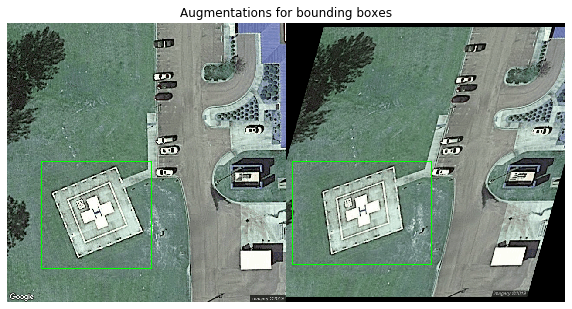

In [85]:
image_aug, box_aug = apply_augmentation_and_display_side_by_side(image, bboxes[0], policy_v3)

In [94]:
images = np.array(
    [image for _ in range(32)],
    dtype=np.uint8
)

https://github.com/matterport/Mask_RCNN/issues/1015
https://www.kaggle.com/c/data-science-bowl-2018/discussion/53495
https://github.com/matterport/Mask_RCNN/issues/768
https://medium.com/@a.karazhay/guide-augment-images-and-multiple-bounding-boxes-for-deep-learning-in-4-steps-with-the-notebook-9b263e414dac
https://imgaug.readthedocs.io/en/latest/source/overview_of_augmenters.html

https://towardsdatascience.com/data-augmentation-for-deep-learning-4fe21d1a4eb9